In [2]:
from PymoNNto import *
import matplotlib.pyplot as plt
import numpy as np

در هر مدل به نورون‌های ورودی جریانی وارد می‌کنم. این جریان از تابعی که در ابتدا تعریف شد پیروی می‌کند. در هربازه زمانی به ترتیب به نیمی از نورون‌ها جریان خدود 2 وارد می‌شود و بعد مدتی بدون جریان . این سه بازه مرتب تکرار میشوند.
بر اساس رابطه ولتاژ که در تمرین های قبلی پیاده شده بود نورون ها افزایش یا کاهش ولتاژ با این جریان خواهند داشت و در نقطه ی استانه اسپایک خواهند داشت. 
جریان ورودی طوری هست که نورون هایی که جریان دریافت کرده اند در ان بازه زمانی انتظار میرود که اسپایک داشته باشند
این اسپایک فعالیت را به لایه خروجی منتقل می‌کند و به ازای اسپایک 3 نورون ورودی لایه خروجی فعالیت نشان می‌دهد.
هدف این است که لایه ی خروجی طوری آموزش داده شود که یک کدینگ مانند کدینگی که در طبقه بندی در شبکه های کلاسیک داریم برای دو الگوی فعالیت ورودی از خود نشان بدهد.
مثلا 01 نشان گر الگوی اول و 10 نشانگر الگوی جریان ورودی دوم باشد.
که به ترتیب به معنی این است که نورون خروجی اول و دوم فعال شده اند.
در روش اس-تی-دی-پی انتظار قوی برای یادگیری نداریم اما نتایج باید با حالت بدون یادگیری تفاوت کند.
در روش تقویتی یادگیری بهتری انتطار می‌رود.
در اس-تی-دی-پی تقویتی تابع پیاده شده عینا همان است در اس-تی-دی-پی پیاده شد. با این تفاوت که دینباله ای برای محاسبه ی دوپامین و پاداش هم به ان اضافه شده و روی اپدیت وزن ها اعمال شده. 
نمودارهای رسم شده به ترتیب زیر هستند:
جریان ورودی
ولتاژ لایه اول، 
ولتاژ لایه دوم، 
اسپایک لایه اول، 
اسپایک لایه دوم، 
تغیرات وزنهای سیناپسی نورون اول لایه خروجی
تغیرات وزنهای سیناپسی نورون دوم لایه خروجی،
و در صورتی که از روش تقویتی استفاده شده باشد در آخر : 
مقدار دوپامین استفاده شده در هر بار آپدیت وزن‌ها به رنگ سبز 
برای اینکه یادگیری انجام شده یا باید دو نمودار اسپایک ها را باهم مقایسه کرد.

In [3]:
class Basic_Behaviour(Behaviour):

    def set_variables(self, neurons):
        self.set_init_attrs_as_variables(neurons)
        neurons.voltage = neurons.get_neuron_vec('uniform', density=0.01)
        self.threshold = neurons.v_threshold
        neurons.dt=1 
        
        neurons.voltage = neurons.get_neuron_vec('uniform')*neurons.v_rest

    def new_iteration(self, neurons):
        firing = neurons.voltage > self.threshold
        neurons.spike = firing.astype(def_dtype) 
        neurons.voltage[firing] = neurons.v_reset
        
        neurons.voltage += ((neurons.v_rest-neurons.voltage)+
                            neurons.R*neurons.I)*(neurons.dt/neurons.tau)
        neurons.voltage *= 0.9 #voltage decay
        #neurons.voltage += neurons.get_neuron_vec('uniform', density=0.01)         
        
class Input_Behaviour(Behaviour):

    def set_variables(self, neurons):
        neurons.I = neurons.get_neuron_vec('uniform', density=0.01)
        for synapse in neurons.afferent_synapses['GLUTAMATE']:
            synapse.W = synapse.get_synapse_mat('uniform',density=1)
            synapse.enabled = synapse.W > 0

    def new_iteration(self, neurons):
        if neurons in neurons['my_neurons']:
            neurons.I = func(100,neurons.iteration)
        for synapse in neurons.afferent_synapses['GLUTAMATE']:
            neurons.voltage += synapse.W.dot(synapse.src.spike)/synapse.src.size*10
            
            
class RSTDP(Behaviour):

    def set_variables(self, synapses):
        self.add_tag('RSTDP')
        self.set_init_attrs_as_variables(synapses)
        synapses.src.trace = synapses.src.get_neuron_vec()
        synapses.dst.trace = synapses.dst.get_neuron_vec()
        synapses.c = np.zeros((2,6))
        synapses.dopamin = 0
        
    def new_iteration(self, s):
        pat1 = [0,0,0,1,1,1]
        pat2 = [1,1,1,0,0,0]
        
        dt = 1
        
        dx = s.src.trace / -s.tau_p + s.src.spike
        dy = s.dst.trace / -s.tau_m + s.dst.spike
        
        s.src.trace += dx * dt
        s.dst.trace += dy * dt
        
        LTD = s.A_m  * s.dst.spike.reshape(2,1) * s.src.trace.reshape(1,6)
        LTP = s.A_p * s.src.spike.reshape(6,1) * s.dst.trace.reshape(1,2)
        dw_stdp = (LTP.T - LTD) * dt
        
        dc = -s.c * dt + dw_stdp * dt
        s.c += dc
        
        def d_reward(src, dst):
            reward = 0
            if (src == pat1).all():
                if dst[0] == 1:
                    reward += 1
                if dst[1] == 1:
                    reward -= 1
                else:
                    reward += 1
            elif (src == pat2).all():
                if dst[1] == 1:
                    reward += 1
                if dst[0] == 1:
                    reward -= 1
                else:
                    reward += 1
            return reward
        
        rewarded_dopamin = d_reward(s.src.spike,s.dst.spike)
        dd = ((-s.dopamin / s.tau_d) + rewarded_dopamin) * dt
        s.dopamin += dd

        dw = s.c * s.dopamin
        
        s.W = np.clip(s.W + dw, 0,1,)
        
        weights[s.src.iteration-1] = s.W
        dweights[s.src.iteration-1] = dw
        dopamin[s.src.iteration-1] = s.dopamin

class STDP(Behaviour):

    def set_variables(self, synapses):
        self.add_tag('STDP')
        self.set_init_attrs_as_variables(synapses)
        synapses.src.trace = np.array(synapses.src.get_neuron_vec())
        synapses.dst.trace = synapses.dst.get_neuron_vec()
        
    def new_iteration(self, s):        
        dt = 1
        
        dx = s.src.trace / -s.tau_p + s.src.spike
        dy = s.dst.trace / -s.tau_m + s.dst.spike
        
        s.src.trace += dx * dt
        s.dst.trace += dy * dt
        
        LTD = s.A_m  * s.dst.spike.reshape(2,1) * s.src.trace.reshape(1,6)
        LTP = s.A_p * s.src.spike.reshape(6,1) * s.dst.trace.reshape(1,2)
        dw = (LTP.T - LTD) * dt
        
        s.W = np.clip(s.W + dw, 0,1,)
        
        weights[s.src.iteration-1] = s.W
        dweights[s.src.iteration-1] = dw

In [4]:
def train_(val,learning):
    
    My_Network = Network()

    My_Neurons = NeuronGroup(net=My_Network, tag='my_neurons', size=val['size'], behaviour={
        1: Basic_Behaviour(R=val['R'], v_rest=val['v_rest'], v_reset=val['v_reset'],
                           v_threshold=val['v_threshold'], tau=val['tau']),
        2: Input_Behaviour(),
        9: Recorder(tag='my_recorder', variables=['n.voltage', 'np.mean(n.voltage)','neurons.I']),
        10: EventRecorder(tag='my_event_recorder', variables=['n.spike'])
    })
    My_Neurons2 = NeuronGroup(net=My_Network, tag='my_neurons2', size=val['size2'], behaviour={
        1: Basic_Behaviour(R=val['R2'], v_rest=val['v_rest2'], v_reset=val['v_reset2'],
                           v_threshold=val['v_threshold2'], tau=val['tau2']),
        2: Input_Behaviour(),
        9: Recorder(tag='my_recorder', variables=['n.voltage', 'np.mean(n.voltage)','neurons.I']),
        10: EventRecorder(tag='my_event_recorder', variables=['n.spike'])
    })

    my_syn = SynapseGroup(net=My_Network, src=My_Neurons, dst=My_Neurons2, tag='GLUTAMATE',behaviour={
        1: learning(tau_p=val['tau_p'],tau_m=val['tau_m'],A_p=val['A_p'],A_m=val['A_m'],tau_d=20)
    })
    My_Network.initialize()

    My_Network.simulate_iterations(iterations)
    
    #plot_input
    for n in range(5):
        plt.plot(My_Neurons['neurons.I',0,'np'].T[n])
    plt.show()
    
    #plot_voltage
    plt.plot(My_Neurons['n.voltage', 0])
    plt.axhline(My_Neurons['Basic_Behaviour', 0].threshold, color='black')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()
    plt.plot(My_Neurons2['n.voltage', 0])
    plt.plot(My_Neurons2['np.mean(n.voltage)', 0], color='black')
    plt.xlabel('iterations')
    plt.ylabel('voltage')
    plt.show()
    
    
    #plot_raster
    plt.scatter(My_Neurons['n.spike.t', 0], My_Neurons['n.spike.i', 0],s=2,c='black')
    plt.xlabel('iterations')
    plt.ylabel('neuron index')
    plt.show()
    plt.scatter(My_Neurons2['n.spike.t', 0], My_Neurons2['n.spike.i', 0],s=2,c='black')
    plt.xlabel('iterations')
    plt.ylabel('neuron index')
    plt.show()
    
    #plot_weights
    for n in range(5):
        plt.plot(weights.T[n][1],c='red')
    plt.xlabel('iterations')
    plt.ylabel('weights')
    plt.show()
    for n in range(5):
        plt.plot(weights.T[n][0],c='blue')
    plt.xlabel('iterations')
    plt.ylabel('weights')
    plt.show()
    
    #plot_dopamin
    if learning == RSTDP:
        plt.plot(dopamin,c='green')
        plt.xlabel('iterations')
        plt.ylabel('dopamin')
        plt.show()

In [5]:
def func(b,t):
    pattern1 = [0,0.05,0.03,2.1,2,2.2]
    pattern2 = [2.1,2,2.2,0,0.02,0.01]
    pattern3 = [0,0,0,0,0,0]
    if t//b%4 == 0:
        return pattern1
    elif t//b%4 == 1:
        return pattern3
    elif t//b%4 == 2:
        return pattern2
    else:
        return pattern3

# 1

مجموعه پارامترهای اول را اول با دو روش آموزشی با 1000 تکرار با بازه های زمانی 1 اجرا می‌کنم.
روی نمودار ولتاژ نوسانات هر دو لایه به وضوح مشاهد میشود.
به ازای الگوی اول 1 نورون از 6 نورون فعال می‌شوند در لایه ورودی و در لایه خروجی یک نورون فعالیت دارد. و نورون بعدی بعد از یک اسپایک دیگر فعالیتی نشان نمی دهد.
به ازای الگوی دوم 2 نورون ورودی اسپایک دارند که در خروجی هیچ فعالیتی نداریم.

در روش دوم هم تقریبا همین وضعیت با تفاوت کوچکی تکرار می‌شود.
در هر کدام از نمودارهای تغیرات وزنی بازه های ثابت زیادی داریم و بعد وزن ها صورت نوسان های پشت سر هم کم و زیاد می‌شود تا در نهایت در یک مقدار دوباره توقف می‌کند و ثابت می‌شود.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 176.527ms


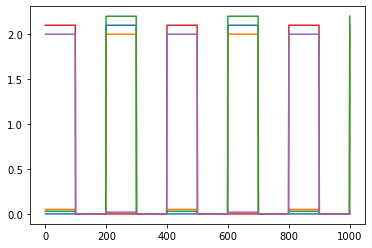

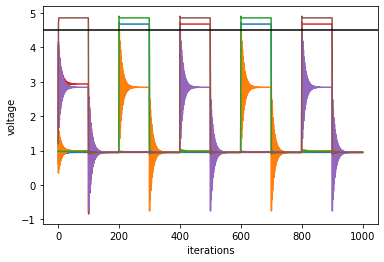

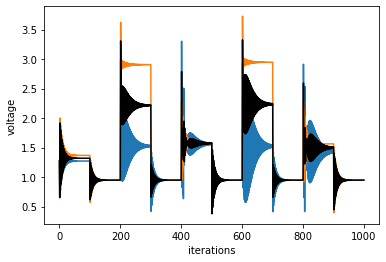

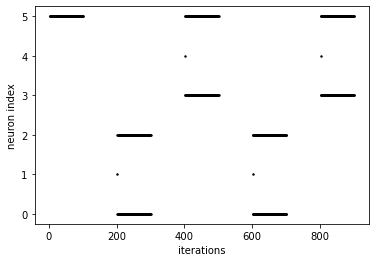

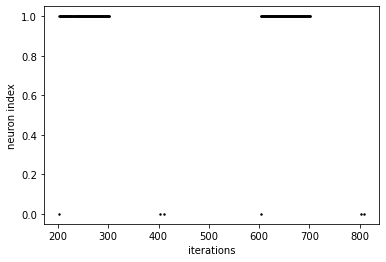

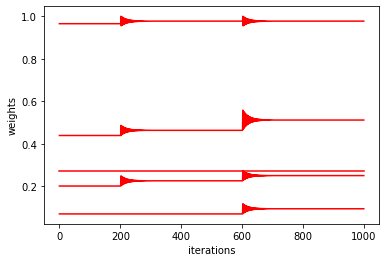

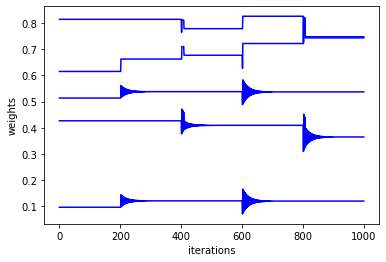

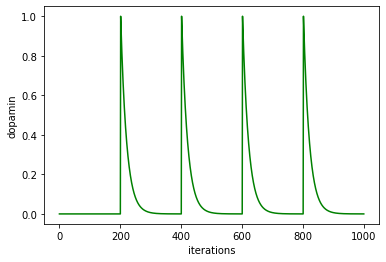

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 153.604ms


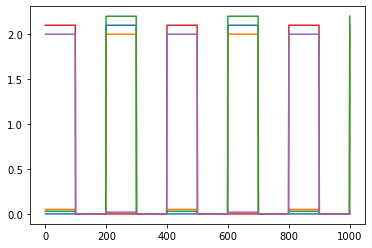

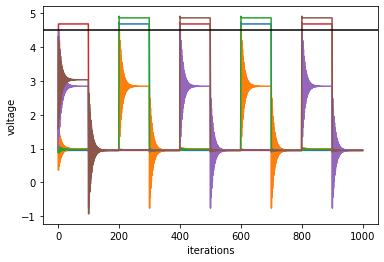

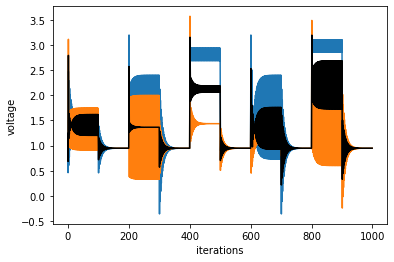

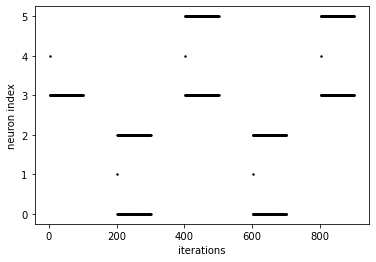

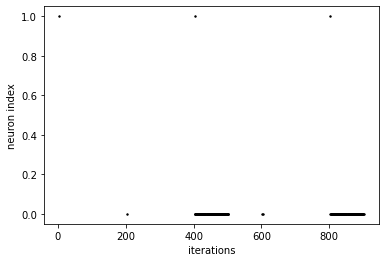

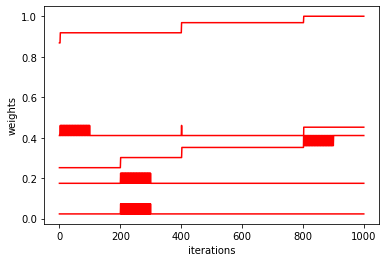

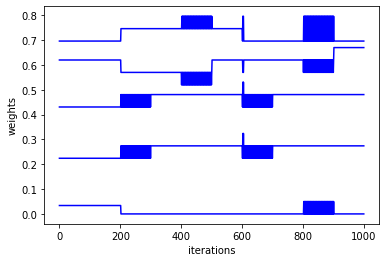

In [80]:
iterations = 1000
val1 = {'size' : 6,
       'R' : 1,
       'v_rest' : 1,
       'v_reset' : 1,
       'v_threshold': 4.5,
       'tau':0.5,
       'size2' : 2,
       'R2': 1,
       'v_rest2' :1,
       'v_reset2' : 1,
       'v_threshold2' : 2.5,
       'tau2' : 0.5,
       'tau_p' : 0.5,
       'tau_m' : 0.5,
       'A_p' : 0.05,
       'A_m' : 0.05,
       'tau_d' : 20
      }
iterations = 1000
weights = np.zeros((iterations,2,6))
dweights = np.zeros((iterations,2,6))
dopamin = np.zeros((iterations,))
train_(val1,RSTDP)
train_(val1,STDP)

# 2

این بار پارامترهای یادگیری را تغیر می‌دهم. مقدارهای
A
را به 0.1 مقدار قبلی و متغیر ثابت تابع تغیرات دوپامین را هم به همین میزان کاهش می‌دهم.
نتیجه وضعیت اسپایک ها ی دولایه مشابه آنچه هست که در بخش قبلی اتفاق افتاد
تغیر اصلی در نمودارهای تغیر وزن اتفاق افتاده. دیگر مقل خالت قبلی نوسانات رفت و برگشتی دیده نمی‌شود. ثبات بیشتری در یکی از نمودارها هست. 

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 207.469ms


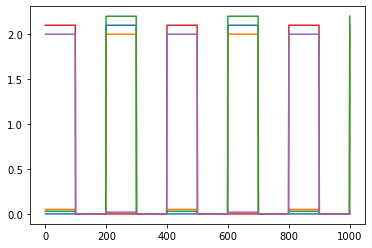

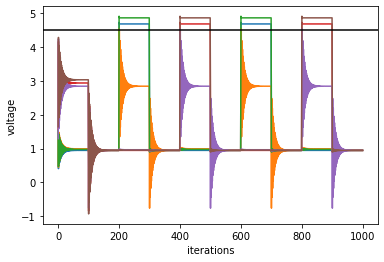

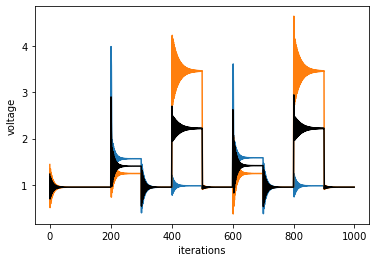

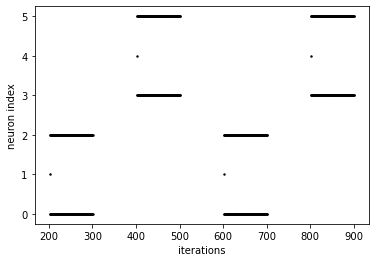

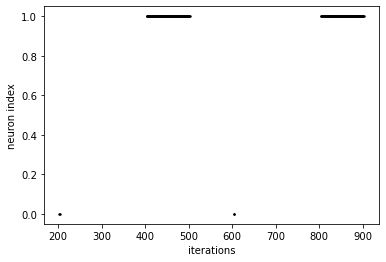

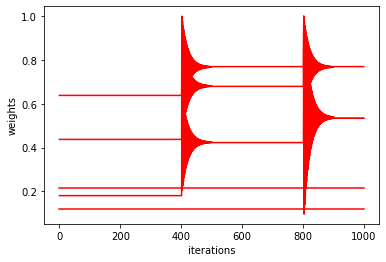

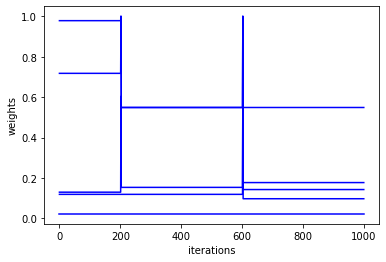

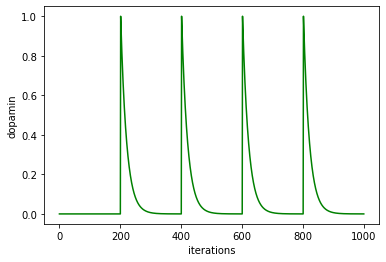

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 192.501ms


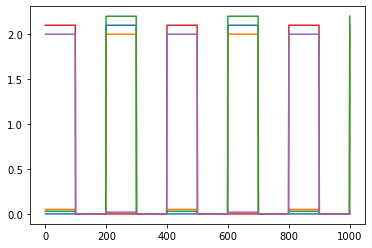

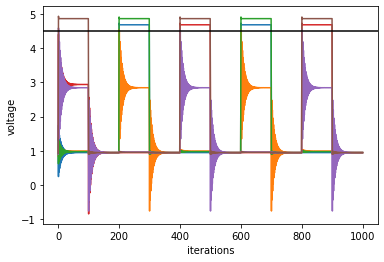

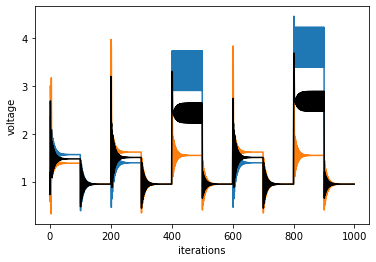

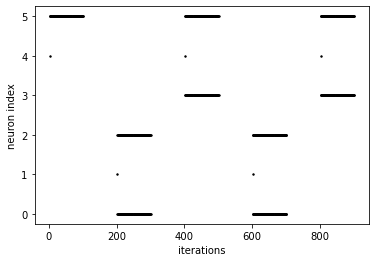

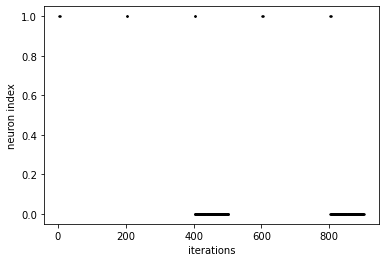

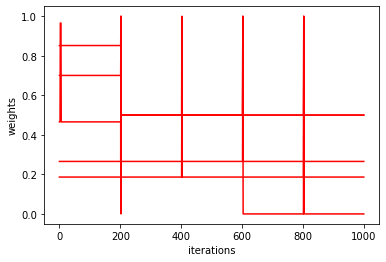

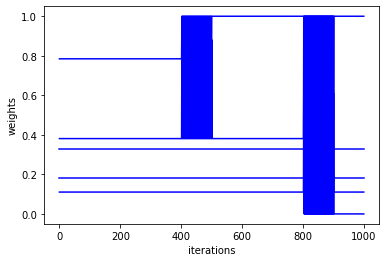

In [87]:
val2 = {'size' : 6,
       'R' : 1,
       'v_rest' : 1,
       'v_reset' : 1,
       'v_threshold': 4.5,
       'tau':0.5,
       'size2' : 2,
       'R2': 1,
       'v_rest2' :1,
       'v_reset2' : 1,
       'v_threshold2' : 2.5,
       'tau2' : 0.5,
       'tau_p' : 0.5,
       'tau_m' : 0.5,
       'A_p' : 0.005,
       'A_m' : 0.005,
       'tau_d' : 2
      }
iterations = 1000
weights = np.zeros((iterations,2,6))
dweights = np.zeros((iterations,2,6))
dopamin = np.zeros((iterations,))
train_(val2,RSTDP)
train_(val2,STDP)

# 3

این بار تلفیقی از پارامترهای یادگیری قبلی را اجرا می‌کنم. مقادیر 
A
مانند مجموعه دوم 
و پارامتر تغیرات دوپامین همان20 باشد.
در خالت تقویتی روی لایه خروجی به ازای الگوی اول یک تک اسپایک نورون دوم را داریم و این نورون به ازای الگوی دیگر فعالیتی نمی‌کند.
به ازای هر دو الگو نورون اول فعالیت اسپایکی منطم دارد!
در روش اس-تی-دی-پی تفاوت بارزتر هست. به ازای یک الگو هر دو فعالیت دارند و به ازای الگوی دیگر فقط یک نورون فعالیت می‌کند. چنانکه انگار به ورودی مقادیر 10 و 11 اختصاص داده باشد.
روی نمودار تغیرات ورنی در هر دو روش پرش های کمی دیده می شود نسبت به دو حالت قبلی.

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 192.588ms


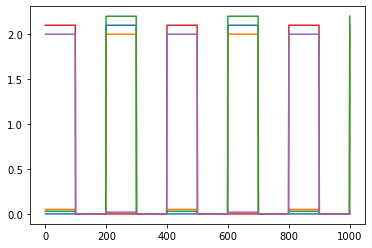

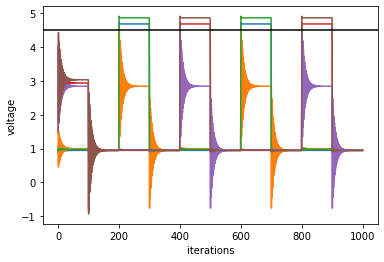

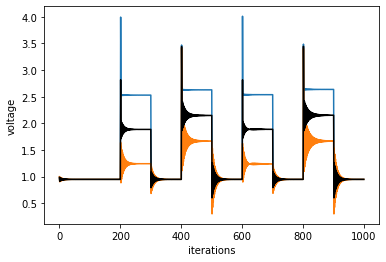

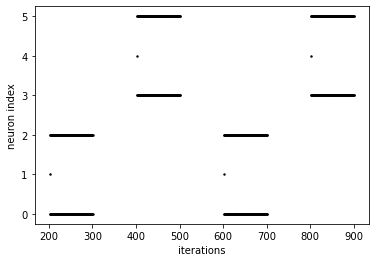

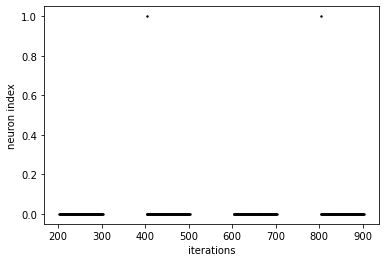

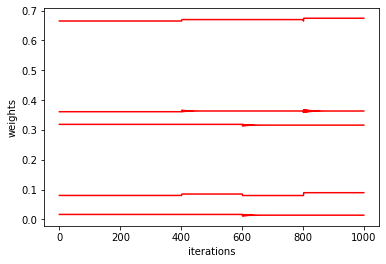

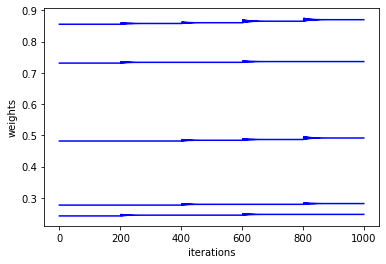

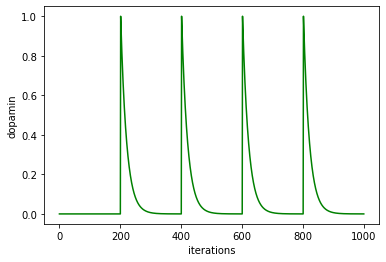

init R
init v_rest
init v_reset
init v_threshold
init tau
init R
init v_rest
init v_reset
init v_threshold
init tau
init tau_p
init tau_m
init A_p
init A_m
init tau_d
1000xBatch: 1/1 (100%) 200.497ms


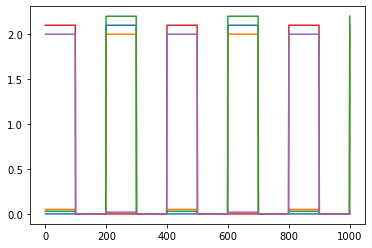

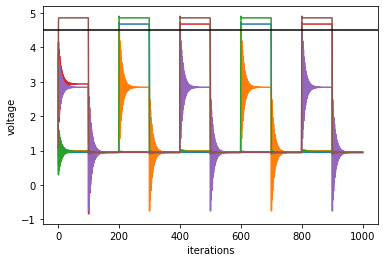

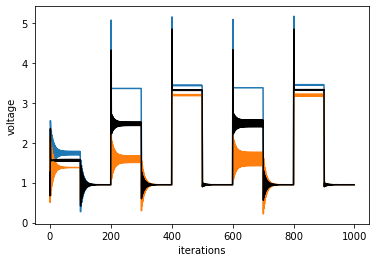

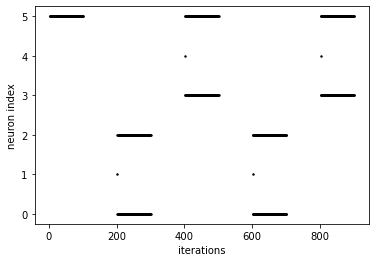

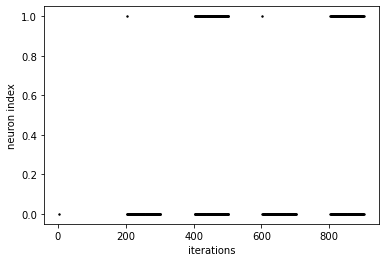

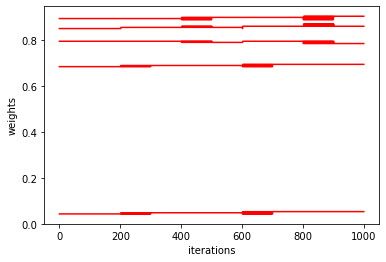

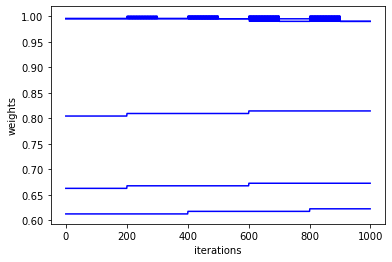

In [6]:
iterations = 1000
val3 = {'size' : 6,
       'R' : 1,
       'v_rest' : 1,
       'v_reset' : 1,
       'v_threshold': 4.5,
       'tau':0.5,
       'size2' : 2,
       'R2': 1,
       'v_rest2' :1,
       'v_reset2' : 1,
       'v_threshold2' : 2.5,
       'tau2' : 0.5,
       'tau_p' : 0.5,
       'tau_m' : 0.5,
       'A_p' : 0.005,
       'A_m' : 0.005,
       'tau_d' : 20
      }
iterations = 1000
weights = np.zeros((iterations,2,6))
dweights = np.zeros((iterations,2,6))
dopamin = np.zeros((iterations,))
train_(val3,RSTDP)
train_(val3,STDP)